In [1]:
import pandas as pd
import psycopg2
import numpy as np
from scipy.stats.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [2]:
import sys 
import os
sys.path.append(os.path.abspath("/home/scidb/HeartRatePatterns/Python"))
from LogisticRegresion import ajustLogisticRegression
from PlotWords import plot_word
from Matrix import convert_matrix
from NMF import auc_model

In [4]:
def savePearson(pearson,dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    insert_statement=('INSERT INTO wordspearson(word,p1,p2,patient,deadPatient)'
                      ' SELECT unnest( %(word)s ) ,'
                      ' unnest( %(p1)s) ,'
                      ' unnest( %(p2)s) ,'
                      ' unnest( %(patient)s) ,'
                      ' unnest( %(deadPatient)s)')
    word=[r['word'] for r in pearson]
    p1=[r['p1'] for r in pearson]
    p2=[r['p2'] for r in pearson]
    patient=[r['patient'] for r in pearson]
    deadPatient=[r['deadPatient'] for r in pearson]
#    print(cur.mogrify(insert_statement,locals()))
    cur.execute(insert_statement,locals())
    conn.commit()
    cur.close()
    conn.close()

In [5]:
def selectPearson(dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    select_statement='SELECT word,p1,p2,patient,deadpatient FROM wordspearson'
#    print(cur.mogrify(select_statement,locals()))
    cur.execute(select_statement)
    select = []
    for row in cur :
        patient=row[3]
        cuantosMueren ="{0:.2%}".format(row[4]/patient)+" de "+str(patient)
        select.append({"word":row[0],"p1":row[1],"p2":row[2],"cuantosMueren":cuantosMueren})
    cur.close()
    conn.close()
    return sorted(select, key=itemgetter('p1'), reverse=True)

In [6]:
def countPatients(word,dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    select_statement='''SELECT count(1),sum(isalive) FROM matrix m LEFT JOIN subjectwords s 
    ON m.subject_id=s.subject_id where m.word = %s GROUP BY m.word'''
#    print(cur.mogrify(select_statement,(word,)))
    cur.execute(select_statement,(word,))
    select = {}
    for row in cur :
        select = {"patient":row[0],"deadPatient":row[1],}
    cur.close()
    conn.close()
    return select

In [7]:
def cleanPearson(dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    delete_statement='DELETE FROM wordspearson'
#    print(cur.mogrify(delete_statement,locals()))
    cur.execute(delete_statement,locals())
    conn.commit()
    cur.close()
    conn.close()

In [7]:
table = convert_matrix(sumvals=False)
table

(590, 18683)


,,aaaaac,aaaaad,aaaaae,aaaaaf,aaaaag,aaaaah,aaaaai,aaaaaj,aaaabb,aaaabc,...,kkb,kke,lab,lbb,lbbb,lbbc,lcc,leb,lib,libb
subject_id,isAlive,,,,,,,,,,,,,,,,,,,,,
20,0,0,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
135,1,0,1,0,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
151,1,1,1,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
177,1,0,1,0,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
214,1,1,1,0,1,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
263,1,0,1,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
279,1,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
283,1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
368,1,1,1,0,1,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [8]:
survived = table.index.labels[1].tolist()
patients = table.values
columns = list(table.columns.values)

In [9]:
cleanPearson()
print("cleanedPearson now reading",len(columns),"columns")
pearsonList = []
for i in range(len(columns)):
    pearson = pearsonr(patients[:,i],survived)
    word = columns[i]
    count = countPatients(word)
    pearsonList.append({'word':word,'p1':pearson[0],'p2':pearson[1],'patient':count['patient'],'deadPatient':count['deadPatient']})
#    print(i,end=", ")
print(" preparedToSavePearson")
savePearson(pearsonList)
print("savedPearson")

cleanedPearson now reading 18683 columns
 preparedToSavePearson
savedPearson


In [10]:
patients_train, patients_test,survived_train, survived_test = train_test_split(patients,survived,test_size=0.2, random_state=42)

In [11]:
print(table.shape)
print(patients_train.shape)
print(patients_test.shape)

(590, 18683)
(472, 18683)
(118, 18683)


In [12]:
model,accuracy_score = ajustLogisticRegression(patients_train,survived_train,patients_test,survived_test)

acurracy is 73.73%


In [13]:
logit_roc_auc = auc_model("Logistic",model,patients_test,survived_test)

Logistic AUC = 0.4782f


In [14]:
model

LogisticRegressionCV(Cs=[0.011143, 0.0113212, 0.0114994, 0.0116776, 0.0118558, 0.012034],
           class_weight=None, cv=5, dual=True, fit_intercept=True,
           intercept_scaling=1.0, max_iter=100, multi_class='ovr',
           n_jobs=-1, penalty='l2', random_state=0, refit=True,
           scoring='roc_auc', solver='liblinear', tol=0.0001, verbose=0)

In [8]:
from operator import itemgetter
pearsonDict = selectPearson()

[{'p2': 3.06102185441199e-07, 'p1': 0.208886190046134, 'word': 'adc', 'cuantosMueren': '89.68% de 155'}, {'p2': 5.97981161316011e-07, 'p1': 0.203783764475214, 'word': 'fdf', 'cuantosMueren': '96.39% de 83'}, {'p2': 3.75580792778002e-06, 'p1': 0.189067111670612, 'word': 'dbda', 'cuantosMueren': '85.07% de 221'}, {'p2': 7.08939354448729e-06, 'p1': 0.183704825193073, 'word': 'fbd', 'cuantosMueren': '87.27% de 165'}, {'p2': 1.0711840622015e-05, 'p1': 0.180136446835082, 'word': 'dff', 'cuantosMueren': '93.18% de 88'}, {'p2': 1.42418528265919e-05, 'p1': 0.177632875427676, 'word': 'ffd', 'cuantosMueren': '91.26% de 103'}, {'p2': 1.44077307621607e-05, 'p1': 0.177530361860175, 'word': 'fff', 'cuantosMueren': '93.83% de 81'}, {'p2': 1.92415256495918e-05, 'p1': 0.174950181904134, 'word': 'bdbd', 'cuantosMueren': '85.79% de 183'}, {'p2': 2.31182473811417e-05, 'p1': 0.173293768721131, 'word': 'addaba', 'cuantosMueren': '90.57% de 106'}, {'p2': 2.75843617467745e-05, 'p1': 0.171685192579126, 'word': 

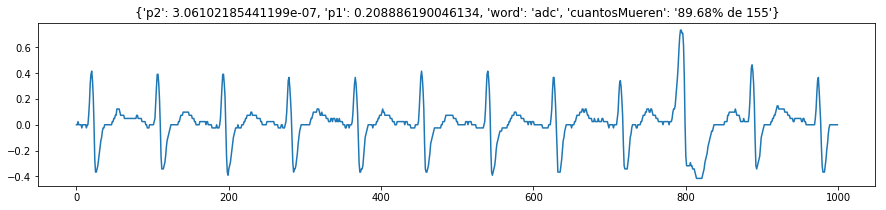

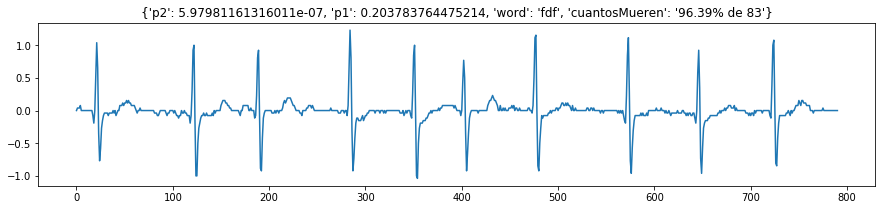

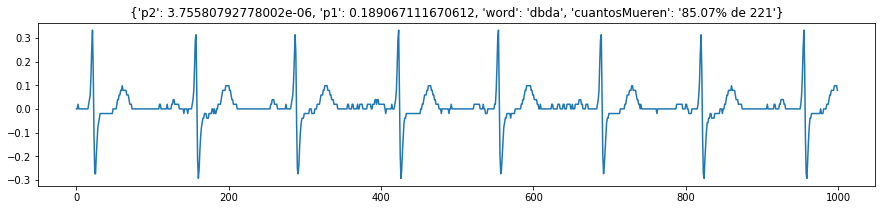

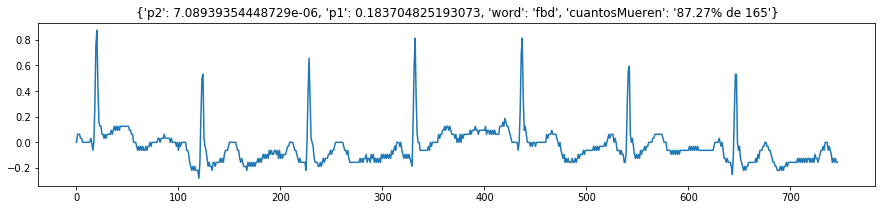

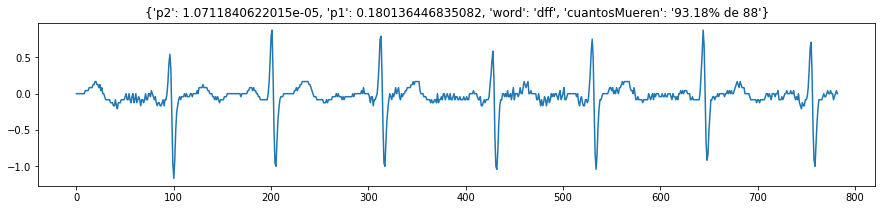

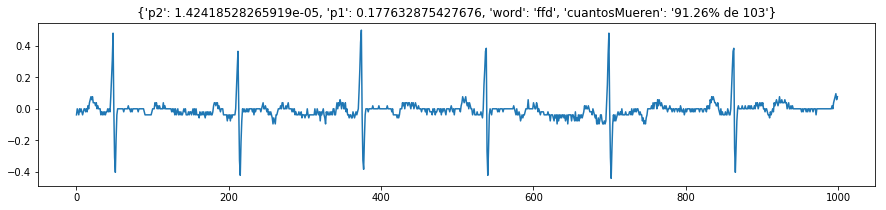

In [11]:
plot_word(pearsonDict[:10])

In [12]:
df = pd.DataFrame(pearsonDict)
df = df.set_index('word')
df = df.sort_values(['p1'], ascending=[False])
df

,cuantosMueren,p1,p2
word,,,
adc,89.68% de 155,0.208886,3.061022e-07
fdf,96.39% de 83,0.203784,5.979812e-07
dbda,85.07% de 221,0.189067,3.755808e-06
fbd,87.27% de 165,0.183705,7.089394e-06
dff,93.18% de 88,0.180136,1.071184e-05
ffd,91.26% de 103,0.177633,1.424185e-05
fff,93.83% de 81,0.177530,1.440773e-05
bdbd,85.79% de 183,0.174950,1.924153e-05
addaba,90.57% de 106,0.173294,2.311825e-05
